In [24]:
%%html
<!-- left align tables -->
<style>
table {margin-left: 0 !important;}
</style>

# Identify Persons of Interest in the Enron Corpus Dataset

## Introduction

The Enron Corporation was one of the largest copmanies in the world energy sector during the 1990s and the early 2000s. At the end of the year 2001 it was revealed that senior Enron managers had used fraudulent accounting techniques to hide their losses in high-risk deals. This has since been known as the Enron scandal and finally led to the bankruptcy of Enron. During the federal investigations of that case records containing financial data of its top executives as well as hundred thousands of emails have been made public.

In this project, I used parts of this data to build a machine learning algorithm to identify employees that have partaken in the fraud case. These persons of interest (POIs) are individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

Throughout this report I have used several helper functions to shorten the code segments. Their code can be found [here](https://github.com/ttsteiger/Udacity_DAND/blob/master/DAND_p5/helper_functions.py) and should be used to follow along with the project.

In [22]:
# import packages
import warnings
warnings.filterwarnings("ignore") # hide warnings in cell output

from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from helper_functions import convert_dict_to_df, get_classifier_scores, get_multi_classifier_scores, \
find_best_parameters, optimize_features_and_parameters, print_classifier_table, scatter_plot, generate_meshgrid, \
plot_boundaries

## Data Exploration

### Dataset Description

The underlying dataset for this project is a combination of Enron email and financial data. The data is present in the precompiled `enron_dataset.pkl` file where it is stored in a dictionary structure. Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. For easier handling, I converted the dcitionary to a pandas `DataFrame` after the import.

The original Enron data can be found only using the following links:

* Email Data (https://www.cs.cmu.edu/~./enron/)
* Financial Data (http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf)

In [3]:
# load dictionary containing the dataset
with open("data/enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# feature list
features = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 
            'director_fees', 'exercised_stock_options', 'expenses', 
            'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
            'restricted_stock_deferred', 'salary', 'total_payments', 
            'total_stock_value', 'email_address', 'from_messages', 
            'from_poi_to_this_person', 'from_this_person_to_poi', 
            'shared_receipt_with_poi', 'to_messages']

# convert specified features to data frame
data_df = convert_dict_to_df(data_dict, features, remove_NaN=False, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=True)

The dataset contains information about 146 different data points. Of those, 18 are marked as POI. It also contains three major feature categories: POI labels, financial features and email features. The 21 feature names and their types are described in the table below.

| Feature                   | Type        |
|-------------------------- | ----------- |
| poi                       | categorical |
| bonus                     | numerical   |
| deferral_payments         | numerical   |
| deferred_income           | numerical   |
| director_fees             | numerical   |
| exercised_stock_options   | numerical   |
| expenses                  | numerical   |
| loan_advances             | numerical   |
| long_term_incentive       | numerical   |
| other                     | numerical   |
| restricted_stock          | numerical   |
| restricted_stock_deferred | numerical   |
| salary                    | numerical   |
| total_payments            | numerical   |
| total_stock_value         | numerical   |
| email_address             | text        |
| from_messages             | numerical   |
| from_poi_to_this_person   | numerical   |
| from_this_person_to_poi   | numerical   |
| shared_receipt_with_poi   | numerical   |
| to_messages               | numerical   |

In a next step, I had a look at missing data within the different input features that could be used for the machine learning model.

In [4]:
# count number of NaN values in each column
print("Number of NaN values in each columns:")
print("-------------------------------------")
print(data_df.isnull().sum())

Number of NaN values in each columns:
-------------------------------------
name                           0
poi                            0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
other                         53
restricted_stock              36
restricted_stock_deferred    128
salary                        51
total_payments                21
total_stock_value             20
email_address                 35
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
to_messages                   60
dtype: int64


Most features in the dataset contain with missing values. One can see that it is based on the finacial data and that only for 86 point a connection to the email dataset could be made (60 data points without email data). For the features 'deferral_payments', 'director_fees', 'loan_advances' and 'restricted_stock_deferred' the fewest amount of  data is available. 

It has to be mentioned that missing financial data does not mean that there is no information available but that not all people received payments in the respective category. On the other hand, missing values in an email feature mean that there are no emails for that individual available and not that it has never written any.

### Outliers

In the financial data a strange outlier was found. This data point had the largest values for all the different financial feature and was identified as the 'TOTAL' column from the spreadsheet. Futhermore, I discovered the key 'THE TRAVEL AGENCY IN THE PARK' which is not the name of a person as well as the data point of 'LOCKHART EUGENE E' that consists of all zero values. These lines were dropped and not considered further.

In [5]:
# drop outlier rows
for n in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']:
    data_df = data_df[data_df['name'] != n]

### Feature Engineering

Before selecting the features that influence 'poi' labelling the most I created two new features. First of all, I thought about looking at the ratio between 'restricted_stock' and 'total_stock_value'. As POIs in general had higher stock options maybe they also tried to prevent those from being restricted leading to low values for the 'restricted_stock_fraction'. Secondly, I created a new variable comparing the number of emails received from and sent to POIs with the total number of email received and sent by each pearson. I would expect POIs to communicate more frequently with other POIs and thus having higher 'poi_email_fraction' values.

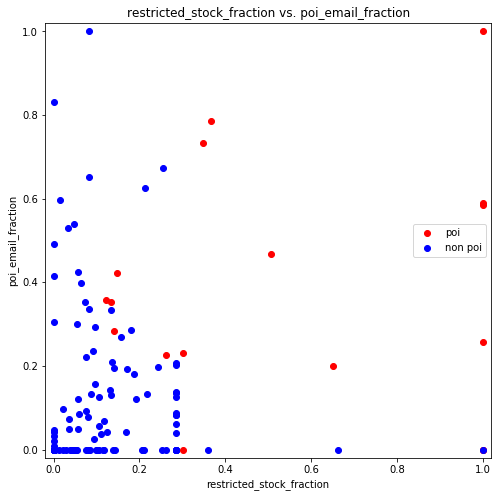

In [6]:
# poi fraction
data_df['restricted_stock_fraction'] = data_df['restricted_stock'] / data_df['total_stock_value']
data_df['poi_email_fraction'] = (data_df['from_poi_to_this_person'] + data_df['from_this_person_to_poi']) / (data_df['from_messages'] + data_df['to_messages'])

# visualization
scatter_plot(data_df, 'restricted_stock_fraction', 'poi_email_fraction')

By visualizing these new featuers one can see that all but one POI have a 'poi_email_fraction' equal to or larger than 0.2. The point that breaks ranks occurs as there is no email data for that person available. Most POIs have 'restricted_stock_fractions' between 0.2 and 0.7 but there are four data points that have all their stocks restricted.

### Feature Selection

To find the features who correlate the most with the `poi` label, I used the `SelectKBest()` method from the `sklearn` package. This algorithms selects the top k features that score best in certain univariate statistical tests. 

As our features in the dataset take on a wide variety of values (ratios between 0 and 1 or stock options of $ 100'000'000) it is important to apply some sort of feature scaling for a meaningful comparison. `SelectKBest()` does this automatically but for the rest of my project I scaled the features using the `MinMaxScaler()` function. This approach simply defines the lowest value as 0, the largest value as 1 and distributes all other ones proportionally between them.

All the features ranked based on their selection score are displayed in the table below.

In [7]:
# data preparation
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi'].astype(int)

# feature scoring
selector = SelectKBest(k=X.shape[1])
selector.fit(X, y)

features = X[selector.get_support(indices=True)].columns.values
scores = selector.scores_
score_list = sorted([(f, s) for f, s in zip(features, scores)], key=lambda tup: tup[1], reverse=True)

# print out scoring table
print("{:<25} {:<10}".format("Feature", "Score"))
print("-------------------------------")
for tup in score_list:
    print("{:<25} {}".format(tup[0], round(tup[1], 2)))

Feature                   Score     
-------------------------------
exercised_stock_options   24.82
total_stock_value         24.18
bonus                     20.79
salary                    18.29
deferred_income           11.46
long_term_incentive       9.92
restricted_stock          9.21
total_payments            8.77
shared_receipt_with_poi   8.59
loan_advances             7.18
expenses                  6.09
poi_email_fraction        5.4
from_poi_to_this_person   5.24
other                     4.19
from_this_person_to_poi   2.38
director_fees             2.13
to_messages               1.65
restricted_stock_fraction 1.09
deferral_payments         0.22
from_messages             0.17
restricted_stock_deferred 0.07


Nine of top ten features come from the financial data and only `shared_receipt_with_poi` comes from the emails. Before moving on, I also looked at these features in more detail by plotting them. An excerpt from that procedure can be found in the scatter matrix of the top five features below.

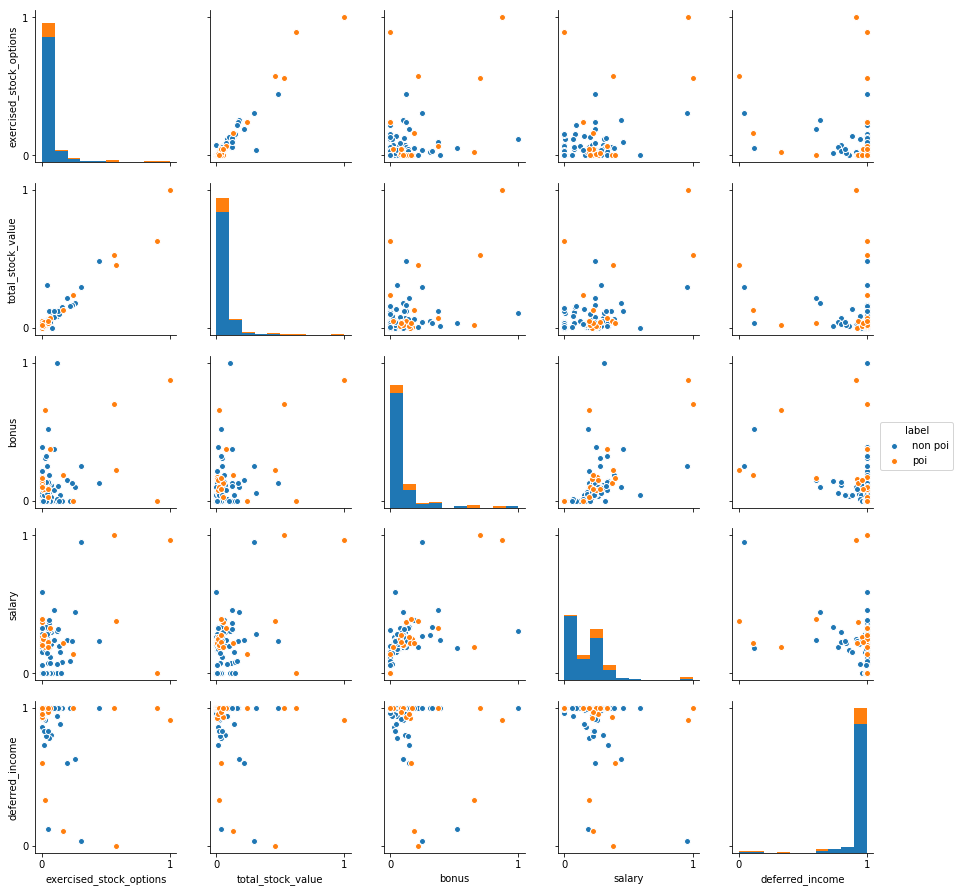

In [8]:
# select top 5 features
top_5_features = [f for (f, s) in list(score_list)[:5]]

# add 'poi' to include this feature in the plotting dataframe
plot_features = top_5_features
plot_features.append('poi')

# create dataframe copy with the desired columns for plotting
data_df_plot = data_df.loc[:, plot_features].fillna(value=0)

# scale all features except for 'poi'
scaler = MinMaxScaler()
data_df_plot[top_5_features[:-1]] = scaler.fit_transform(data_df_plot[top_5_features[:-1]])

# create 'label' feature as 'hue' input for sns.pairplot() 
data_df_plot['label'] = 0
data_df_plot.loc[data_df_plot['poi'] == True, 'label'] = 'poi'
data_df_plot.loc[data_df_plot['poi'] == False, 'label'] = 'non poi'

# remove 'poi' feature
data_df_plot.drop(['poi'], axis=1, inplace=True)

# create pairplot
fig = sns.pairplot(data_df_plot, hue="label", diag_kind="hist")  

# format axes
for i, axes in enumerate(fig.axes):
    for j, ax in enumerate(axes):
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.set_xticklabels([0, 1])
        ax.set_xticks([0, 1])
        ax.set_yticklabels([0, 1])
        ax.set_yticks([0, 1])

plt.show()

The scatter matrix shows that the top two features 'exercised_stock_options' and 'total_stock_value' strongly correlate with each other. This manifests by the linear relation visible in their scatter plots. Thus we will only use one of them, namely 'exercised_stock_options' which achieved a higher feature score.

Furthermore, one can observe that the the values for the 'deferred_income' are negative and most values cluster around the scaled maximum which is equal to a deferred income of 0.

Additionaly, I observed that 'loan_advances' contains only 3 non-zero values and therefor I will also not use it for my model.

The two features that I ruled out were replaced with the next best scoring ones: 'expenses' and 'poi_email_fraction'.

None of my engineered features achieved a mentionable score and they will not be used in the next steps.

After my analysis of the individual features I ended up with the following top ten features ordered based on their scorings:

* exercised_stock_options
* bonus
* salary
* deferred_income 
* long_term_incentive
* restricted_stock
* total_payments
* shared_receipt_with_poi
* expenses
* poi_email_fraction

In [9]:
# store top 10 features in a list
top_10_features = [f for (f, s) in list(score_list)[:10]]
top_10_features.extend(['expenses', 'poi_email_fraction'])
top_10_features = [i for i in top_10_features if i not in ['total_stock_value', 'loan_advances']]

## Algorithm Selection and Tuning


A lot of different classification algorithms could be applied to the identification of the POI labels. I focused on the following classifiers: 

* Logistic Regression
* Gaussian Naive Bayes
* Support Vector Classifier
* KNeighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* AdaBoost Classifier

Since the dataset for this project is imbalanced, meaning that there are a lot more non-POI data points than POI ones, I used the `StratifiedShuffleSplit` method to create 100 random folds of different training and test sets with a test size of 33 % each. Using this method ensures that each fold preserves the percentage of samples for each class. Otherwise we might end up with train or test samples that do not contain any POI data points. 

This approach is one possible cross-validation method. To validate our model it is import to ensure that it generalizes well to any dataset and does not overfit to a single specific training set. By splitting the data into training and test set multiple times we try to assess model performance independently of the performed split.

For the evaluation of our machine learning algorithms I used three different metrics. The 'Accuracy' stands for the number of correct predictions in relation to all predictions. As there are a lot of non-POI data points accuracy tends to be rather high for all the different models and we need to consider different scoring approaches. 

The 'Recall' score counts the number of POI data points that were actually caught by the model compared to the total number of POIs in the set. 

'Precision' on the other hand is the ratio of correctly classified POIs to the total number of classified POIs. This score tells how precise our recall rate was.

Applied to our dataset and problem I would give the most weight to the recall score. It is important that all POIs are identified and it is not too bad if we start looking into people that are classified as POI but were actually innocent. Nevertheless, precision should be as high as possible.

For each fold, the scores were evaluated and a mean score was calculated. The mean metric values for all the different models are reported in the table below.

In [10]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int)

# classifier names and objects    
names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Classifier', 'KNeighbors Classifier', 
         'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
classifiers =[LogisticRegression(random_state=42),
              GaussianNB(),
              SVC(random_state=42),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42)]

# create score overview table
scores = get_multi_classifier_scores(names, classifiers, X, y, random_state=42)
print_classifier_table(scores)

Classifier                 Accuracy  Precision  Recall  
--------------------------------------------------------
Logistic Regression        0.8748    0.2217     0.05    
Gaussian Naive Bayes       0.8417    0.3783     0.3433  
Support Vector Classifier  0.875     0.0        0.0     
KNeighbors Classifier      0.8644    0.1067     0.0267  
Decision Tree Classifier   0.8146    0.285      0.2967  
Random Forest Classifier   0.8656    0.2873     0.1167  
AdaBoost Classifier        0.8402    0.297      0.2267  


The table above shows that most algorithms achive very similar accuracy scores. This can be attributed to the number of non POIs that are classified correctly. But looking at precsion and recall we can already see major differences between the models. The lowest scores were achived using logistic regression, support vector and k-nearest neighbors classification. Surprisingly, the Gaussian Naive Bayes classifier showed the best performance without any fine tuning.

After just looking at the different algorithm performances using all of the top 10 features, I visualized the model performances as a function of the number of input features in the plot below.

In [11]:
# dictionary to store all results
clf_scores = {}
for n in names:
    clf_scores[n] = {"accuracy": [], 'precision': [], 'recall': []}

# loop trough features
for i in range(1, len(top_10_features) + 1):
    features = top_10_features[:i]
    X_i = X.loc[:, features]
    
    scores = get_multi_classifier_scores(names, classifiers, X_i, y, random_state=None)
    for n, score in scores.items():
        accuracy = score['accuracy']
        precision = score['precision']
        recall = score['recall']
        
        clf_scores[n]['accuracy'].append(accuracy)
        clf_scores[n]['precision'].append(precision)
        clf_scores[n]['recall'].append(recall)

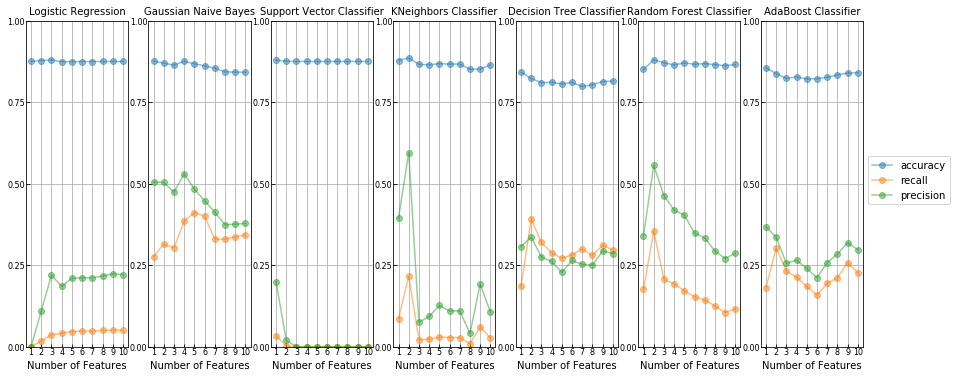

In [12]:
# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(names), figsize=(15, 6))
n_features = np.arange(1, len(top_10_features) + 1)

for ax, title in zip(axs, names):
    for m in clf_scores[title].keys():
        ax.plot(n_features, clf_scores[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0], yticks=np.arange(0, 1.1, 0.25))
        ax.set_xlabel("Number of Features", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)
        ax.grid()
        
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))
plt.show()

The plot above shows that 'Logistic Regression', 'Support Vector Classifier' and 'KNeighbors Classifier' in general tend to show the weakest performance independently of the number of input features. The 'Gaussian Naive Bayes', 'Decision Tree', and 'Random Forest' models show their best results with the top two to top six features, Most plots display an optimum performance for a low number of features used and only the 'AdaBoost Classifier' delivers good results for a low as well as a high number of input features.

My next step was to look at the different parameters each of the classifier model has. For this, I used the `GridSearchCV()` function. This allows to do an exhaustive search over all the provided input parameters for an estimator and returns the parameter combination that achieved the best evaluation score. As optimization needs to focus on a specific scoring metric, I repeated parameter optimization for both precision and recall.

The optimum parameter and classifier combinations can be found in the printout below.

In [13]:
# parameter tuning
param_grid = {'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              'Gaussian Naive Bayes': {}, # GaussianNB has no parameters
              'Support Vector Classifier': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              'KNeighbors Classifier': {'n_neighbors': [1, 2, 5, 10, 20],
                                        'algorithm': ['ball_tree', 'kd_tree', 'brute']},
              'Decision Tree Classifier': {'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'Random Forest Classifier': {'n_estimators': [1, 2, 5, 10, 20], 
                                           'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'AdaBoost Classifier': {'n_estimators': [1, 2, 5, 10, 20]}}

# optimize precision
precision_scores = find_best_parameters(names, classifiers, X, y, param_grid, score='precision', random_state=42)
print_classifier_table(precision_scores)
print()

# optimize recall
recall_scores = find_best_parameters(names, classifiers, X, y, param_grid, score='recall', random_state=42)
print_classifier_table(recall_scores)

Classifier                 Parameters                                                         Precision  
---------------------------------------------------------------------------------------------------------
Logistic Regression        {'C': 10}                                                          0.3512     
Gaussian Naive Bayes       {}                                                                 0.3783     
Support Vector Classifier  {'C': 100}                                                         0.2417     
KNeighbors Classifier      {'n_neighbors': 1, 'algorithm': 'ball_tree'}                       0.3054     
Decision Tree Classifier   {'min_samples_split': 5, 'criterion': 'gini'}                      0.3035     
Random Forest Classifier   {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 20}  0.355      
AdaBoost Classifier        {'n_estimators': 2}                                                0.3383     

Classifier                 Parameters        

Optimizing the model parameters confirmed the results from varying the number of input features. Because of that, the 'Logistic Regression', 'Support Vector Classifier' and 'KNeighbors Classifier' models were dropped and not considered further for the rest of my analysis.

In a next step I tried to optimize the number of input features as well as the parameters simultaneously to find the best combinations for the remaining four classifiers.

In [14]:
# select best classifiers
top_ixs = [1, 4, 5, 6]
top_names = [n for i, n in enumerate(names) if i in top_ixs]
top_classifiers = [clf for i, clf in enumerate(classifiers) if i in top_ixs]

top_param_grid = {k: v for k, v in param_grid.items() if k not in ['Logistic Regression', 
                                                                   'Support Vector Classifier', 
                                                                   'KNeighbors Classifier']}

In [15]:
# optimize precision scores by varying parameters and number of top input features
precision_scores = optimize_features_and_parameters(top_names, top_classifiers, X, y, top_10_features, top_param_grid, 
                                                    score='precision', random_state=42)
print_classifier_table(precision_scores)
print()

# optimize recall scores by varying parameters and number of top input features
recall_scores = optimize_features_and_parameters(top_names, top_classifiers, X, y, top_10_features, top_param_grid, 
                                                    score='recall', random_state=42)
print_classifier_table(recall_scores)

Classifier                I  Parameters                                                         Precision  
-----------------------------------------------------------------------------------------------------------
Gaussian Naive Bayes      4  {}                                                                 0.5305     
Decision Tree Classifier  1  {'min_samples_split': 20, 'criterion': 'gini'}                     0.3997     
Random Forest Classifier  2  {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 10}  0.6202     
AdaBoost Classifier       1  {'n_estimators': 1}                                                0.5891     

Classifier                I  Parameters                                                            Recall  
-----------------------------------------------------------------------------------------------------------
Gaussian Naive Bayes      5  {}                                                                    0.4117  
Decision Tree Classifier  2

Based on the metrics above I selected my two best performing models. As I selected recall as the most important metric for the model I selected the conditions based on recall optimization.

The two best performing models, their input features and parameter settings are summarized in the table below:

| Model                    | Parameters | Input Features |
|--------------------------|------------|----------------|
| Gaussian Naive Bayes     | None       | <ul><li>'exercised_stock_options'</li><li>'bonus'</li><li>'salary'</li><li>'deferred_income'</li><li>'long_term_incentive'</li></ul> |
| Random Forest Classifier | <ul><li>'criterion': 'entropy'</li><li>'n_estimators': 20</li><li>'min_samples_split': 2</li></ul> | <ul><li>'exercised_stock_options'</li><li>'bonus'</li></ul> |

Using these settings I calculated all three evaluation metrics to select my final best model.

In [16]:
# Gaussian Naive Bayes 
gnb_clf = GaussianNB()
gnb_features = ['exercised_stock_options', 'bonus', 'salary', 'deferred_income', 'long_term_incentive']
gnb_X = X[gnb_features]

# Random Forest Classifier
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=20, min_samples_split=2, random_state=42)
rf_features = ['exercised_stock_options', 'bonus']
rf_X = X[rf_features]

In [17]:
# calculation evalutation metrics for both models
gnb_scores = get_classifier_scores(gnb_clf, gnb_X, y, random_state=42)
rf_scores = get_classifier_scores(rf_clf, rf_X, y, random_state=42)

# create score table
clf_scores = OrderedDict()
for n, scores in zip(['Gaussian Naive Bayes', 'Random Forest Classifier'], [gnb_scores, rf_scores]):
    clf_scores[n] = OrderedDict()
    clf_scores[n]['accuracy'] = scores[0]
    clf_scores[n]['precision'] = scores[1]
    clf_scores[n]['recall'] = scores[2]
    
print_classifier_table(clf_scores)

Classifier                Accuracy  Precision  Recall  
-------------------------------------------------------
Gaussian Naive Bayes      0.8677    0.4835     0.4117  
Random Forest Classifier  0.8808    0.5722     0.3933  


Both classifiers achieved very similar accuarcy and recall scores. But the Random Forest model outperformed the Gaussian Naive Bayes one on precision. Hence, the Random Forest classifier using only two input features, 'exercised_stock_options' and 'bonus', with three specified parameters (`criterion='entropy'`, `n_estimators=20`, `min_samples_split=2`) is my final pick with wich I achieved the best performance during my analysis. The performance metrics above show that this model classifed 88% of all people correctly. Of all the people it classified as POIs, 57% are actually POIs and 39% of all the POIs in the data set were caught by the model.

As the model uses only two features, I plotted the decision boundaries of the classifier in a two-dimensional graph.

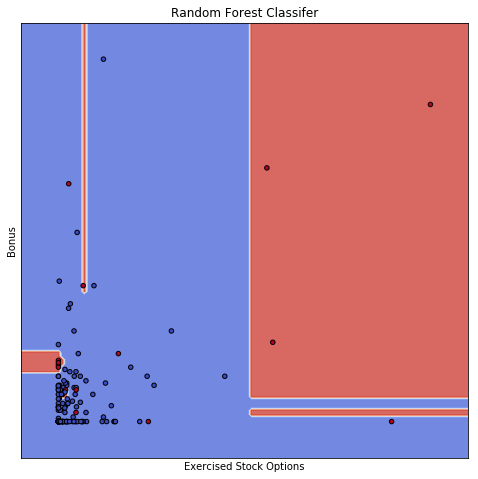

In [18]:
# generate meshgrid
X0, X1 = X['exercised_stock_options'].values, X['bonus'].values
xx, yy = generate_meshgrid(X0, X1)

# create scatter plot and decision boundary
fig, ax = plt.subplots(figsize=(8, 8))

plot_boundaries(ax, rf_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set(title='Random Forest Classifer',
       xlabel='Exercised Stock Options', xlim=[xx.min(), xx.max()], xticks=[], 
       ylabel='Bonus', ylim=[yy.min(), yy.max()], yticks=[])

plt.show()

The classifier creates a rather simple decision boundary. It catches most POIs with the large area in the upper right and the smaller one on the left side. Strangely it misses the POI in the lower right corner just slightly with the thin red line.

## PCA Approach

Instead of selecting the features that influence target labels the most one can use principal component analysis (PCA) to condense all features into linearly uncorrelated variables. In a last part of my project, I wanted to see if can achieve better results using PCA than selecting individual input features.

For this, I transformed the features into two to ten principal components and calculated the three evaluation metrics for my four best performing models and plotted the results versus the number of principal components.

In [19]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int)

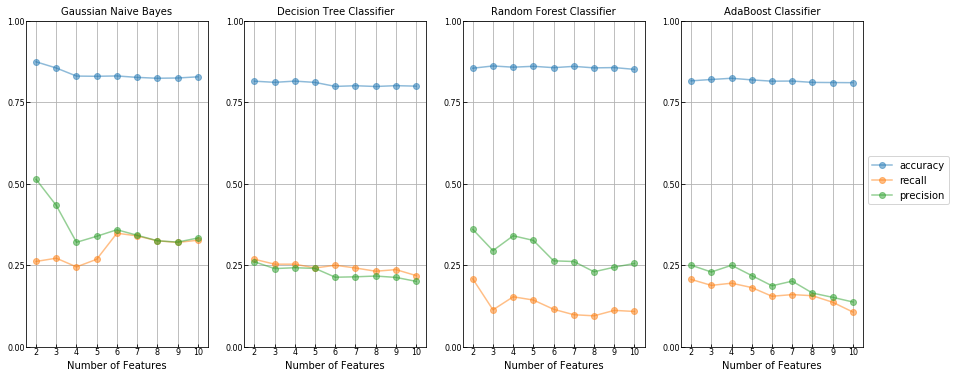

In [20]:
# calculate evalutation metrics for 1 to 10 principal components
# dictionary to store all results
clf_scores = {}
for n in top_names:
    clf_scores[n] = {"accuracy": [], 'precision': [], 'recall': []}

for n_pc in range(2, 11):
    pca = PCA(n_components=n_pc)
    X_pca = pca.fit_transform(X.values)
    
    scores = get_multi_classifier_scores(top_names, top_classifiers, X_pca, y, random_state=None)
    for n, score in scores.items():
        accuracy = score['accuracy']
        precision = score['precision']
        recall = score['recall']
        
        clf_scores[n]['accuracy'].append(accuracy)
        clf_scores[n]['precision'].append(precision)
        clf_scores[n]['recall'].append(recall)

# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(top_names), figsize=(15, 6))
n_pc = np.arange(2, 11)

for ax, title in zip(axs, top_names):
    for m in clf_scores[title].keys():
        ax.plot(n_pc, clf_scores[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[1.5, 10.5], xticks=n_pc, ylim=[0.0, 1.0], yticks=np.arange(0, 1.1, 0.25))
        ax.set_xlabel("Number of Features", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)
        ax.grid()

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.6))
plt.show()

The classifiers show similarly high accuracy scores compared to the results without PCA. Also, accuracy is not very much affected by the number of features used. Precision and recall are lower for all four algorithms when using principal components and also tend to decrease for higher feature numbers.

Again I also wanted to have a look at the decision boundaries of the classifiers when using only two features.

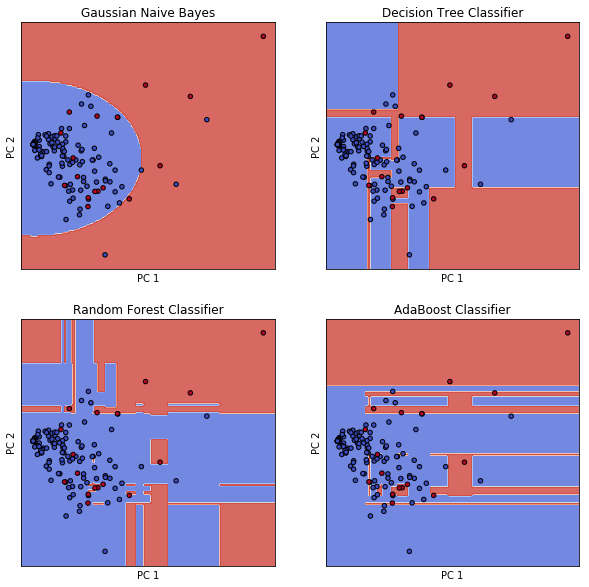

In [21]:
# pca transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.values)

# set up 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# generate meshgrid
X0, X1 = X_pca[:, 0], X_pca[:, 1]
xx, yy = generate_meshgrid(X0, X1)

# create scatter plot and decision boundary
for ax, title, clf in zip(axs.flatten(), top_names, top_classifiers):
    clf.fit(X_pca, y.values)
    plot_boundaries(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set(title=title,
           xlabel='PC 1', xlim=[xx.min(), xx.max()], xticks=[], 
           ylabel='PC 2', ylim=[yy.min(), yy.max()], yticks=[])

plt.show()

The Gaussian Naive Bayes classifier creates an elliptical decision boundary that that does not seem very good at separating the cluster that contains most data points but recognizes most POIs that lay farther outside. The other three models show somewhat more complicated decision boundaries but achive very similar results. They catch most POIs in the top right area but fail to classify all people in the clustered lower left corner.

In conclusion, I did not observe signs of better performance when using PCA compared to standard feature selection.

## Conclusion

In this project I analysed email and financial data that was made public during the Enron fraud trial. Goal was to build a classifier that reliably identifies persons of interest.

I started by having a closer look at the dataset. I investigated missing values, removed outliers, created two new features and selected the features influencing POI status the most.

Afterwards, I experimented with various classifer, feature and parameter combinations until I found the one scoring the highest accuracy, precision and recall scores. As the dataset is heavily imbalanced (much more non-POI data points than POI ones) cross-validation is an important tool to ensure that the model does not overfit but generalizes well independently of the training and test data split.

Before determining the best classifier I also wanted to see if using PCA instead of selecting individual input features deliveres better prediction results. I varied the number of principal components between two and ten but could not observe increased performance.

Finally, I ended up with a Random Forest classifier using 'exercised_stock_options' and 'bonus' as input features and set the following parameters: `criterion='entropy'`, `n_estimators=20`, `min_samples_split=2`. With this setup I achieved an accuracy of 88%, a precision of 57% and a recall rate of 39%.